In [1]:
import sys
sys.path.append("./pilot_folder")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os.path as osp
from glob import glob
from tqdm.notebook import tqdm
import re
from pathlib import Path
import pandas as pd

In [4]:
from typing import Any
from argparse import Namespace
import typing

class DotDict(Namespace):
    """A simple class that builds upon `argparse.Namespace`
    in order to make chained attributes possible."""

    def __init__(self, temp=False, key=None, parent=None) -> None:
        self._temp = temp
        self._key = key
        self._parent = parent

    def __eq__(self, other):
        if not isinstance(other, DotDict):
            return NotImplemented
        return vars(self) == vars(other)

    def __getattr__(self, __name: str) -> Any:
        if __name not in self.__dict__ and not self._temp:
            self.__dict__[__name] = DotDict(temp=True, key=__name, parent=self)
        else:
            del self._parent.__dict__[self._key]
            raise AttributeError("No attribute '%s'" % __name)
        return self.__dict__[__name]

    def __repr__(self) -> str:
        item_keys = [k for k in self.__dict__ if not k.startswith("_")]

        if len(item_keys) == 0:
            return "DotDict()"
        elif len(item_keys) == 1:
            key = item_keys[0]
            val = self.__dict__[key]
            return "DotDict(%s=%s)" % (key, repr(val))
        else:
            return "DotDict(%s)" % ", ".join(
                "%s=%s" % (key, repr(val)) for key, val in self.__dict__.items()
            )

    @classmethod
    def from_dict(cls, original: typing.Mapping[str, any]) -> "DotDict":
        """Create a DotDict from a (possibly nested) dict `original`.
        Warning: this method should not be used on very deeply nested inputs,
        since it's recursively traversing the nested dictionary values.
        """
        dd = DotDict()
        for key, value in original.items():
            if isinstance(value, typing.Mapping):
                value = cls.from_dict(value)
            setattr(dd, key, value)
        return dd

from collections import defaultdict

class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


def create_list_defaultdict():
    return defaultdict(list)


defaults_d = {
     'minimize_property': False,
     'mp_index': 0,
     'latent_gamma': 1.,
     'use_lipinski_context': True,
     'context_fixed': None,
     'encode_ligands': False,
     'model_path': None,
     'skip_existing': False,
     'dataset_root': None, 
     'save_xyz': False, 
     'calculate_energy': False, 
     'num_ligands_per_pocket_to_sample': 100,
     'num_ligands_per_pocket_to_save': 100, 
     'build_obabel_mol': False, 
     'dist_cutoff': 5.0, 'ddim': False, 'eta_ddim': 1.0, 
     'relax_mol': False, 'sanitize': False, 'max_relax_iter': 200,
     'test_dir_10A': None, 
     'test_list': None, 
     'save_dir': None,
     'filter_by_posebusters': False, 
     'filter_by_lipinski': False,
     'filter_by_sascore': False,
     'sascore_threshold': 0.7, 
     'filter_by_docking_scores': False, 
     'docking_scores': None, 
     'omit_posebusters': False, 'omit_posecheck': False, 
     'ckpt_property_model': None, 'ckpt_sa_model': None, 'ckpts_ensemble': [], 
     'property_classifier_guidance': False, 'property_classifier_self_guidance': False, 
     'property_classifier_guidance_complex': False, 'classifier_guidance_scale': 0.0001,
     'joint_importance_sampling': False, 
     'max_sample_iter': 20, 
 }

In [5]:
import rdkit
from rdkit import Chem
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Batch, Data

In [6]:
from experiments.data.data_info import GeneralInfos as DataInfos
from experiments.utils import get_lipinski_properties, calculate_sa
from experiments.data.ligand.ligand_dataset_nonadaptive import (
    LigandPocketDataModule as DataModule,
)
from experiments.data.utils import mol_to_torch_geometric

# pocket preparation and ligand generation functions
from experiments.utils import (
    prepare_data,
    prepare_data_and_generate_ligands
)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [7]:
from Bio.PDB import PDBParser

In [8]:
# regex for extracting docking score in string
rg = r'[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?'
extract_score = lambda x: float(re.findall(rg, x.GetProp("REMARK").split("\n")[0].strip())[0])

def get_top_k(arr, k=0.1):
    arr = np.sort(arr)
    ids = int(k * len(arr))
    return arr[:ids]

In [9]:
class TmpCfg():
    def __init__(self, dataset_root, dataset, regression_property, batch_size=16) -> None:
        self.remove_hs = True
        self.dataset_root = dataset_root
        self.batch_size = batch_size
        self.num_workers = 1
        self.dataset = dataset
        self.joint_property_prediction = True
        self.regression_property = regression_property
        self.property_training = False
        self.num_bond_classes = 5
        self.num_charge_classes = 6

In [10]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device("cpu")

## Kinodata
Here we show inference code how to generate ligands on the Kinodata dataset.  
Notice we leverage the 5A dataset due to computational efficiency and dataset without docking scores.  
The model however was trained on `sa_score` and `ic50_score` prediction.

In [11]:
ckpt = Path("./pilot_folder/kinodata/modeldir/")

In [12]:
cfg = TmpCfg(dataset_root='./pilot_folder/kinodata/dataset',
             dataset="kinodata",
             regression_property=["sa_score", "ic50_score"],
             batch_size=16)
datamodule = DataModule(cfg)
dataloader = datamodule.val_dataloader()
pocket_data = next(iter(dataloader)).to(device)
pocket_data

/sharedhome/let55/miniforge3/envs/e3mol/lib/python3.10/site-packages/torch_geometric/data/lightning/datamodule.py:49: UserWarning: The 'shuffle=True' option is ignored in 'LigandPocketDataModule'. Remove it from the argument list to disable this warning
  warnings.warn(f"The 'shuffle={kwargs['shuffle']}' option is "
/sharedhome/let55/miniforge3/envs/e3mol/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


DataBatch(x=[423], edge_index=[2, 930], edge_attr=[930], pos=[423, 3], pos_batch=[423], pos_ptr=[17], charges=[423], smiles=[16], is_aromatic=[423], is_in_ring=[423], is_h_donor=[423], is_h_acceptor=[423], hybridization=[423], mol=[16], pos_lig=[423, 3], x_lig=[423], pos_pocket=[2465, 3], pos_pocket_batch=[2465], pos_pocket_ptr=[17], x_pocket=[2465], lig_mask=[423], pocket_mask=[2465], pocket_ca_mask=[2465], ic50=[16], batch=[423], ptr=[17])

In [13]:
dataset_info = DataInfos(datamodule=datamodule, cfg=cfg)
smiles_list = None

histogram = os.path.join(
                        cfg.dataset_root, "size_distribution.npy"
                    )
histogram = np.load(histogram).tolist()

In [14]:
list(map(len, (datamodule.train_dataset, datamodule.val_dataset, datamodule.test_dataset)))

[105138, 310, 136]

#### Load the trainer model class

In [15]:
from experiments.diffusion_discrete_pocket import Trainer
model = Trainer.load_from_checkpoint(ckpt / "best_valid.ckpt",
                                     histogram=histogram,
                                     dataset_info=dataset_info,
                                     smiles_list=datamodule.train_dataset.smiles,
                                     run_evaluation=True,
                                     strict=True,
).to(device)

Model without modeling explicit hydrogens
Entropy of n_nodes: H[N] 7.8368940353393555


In [16]:
ff = torch.load(ckpt / "best_valid.ckpt", map_location=device)
model.load_state_dict(ff["state_dict"])
if isinstance(model.hparams.regression_property, str):
    model.hparams.regression_property = model.hparams.regression_property.split(",")
model

Trainer(
  (model): DenoisingEdgeNetwork(
    (time_mapping_atom): DenseLayer(
      in_features=1, out_features=256, bias=True
      (activation): Identity()
    )
    (time_mapping_bond): DenseLayer(
      in_features=1, out_features=128, bias=True
      (activation): Identity()
    )
    (atom_mapping): DenseLayer(
      in_features=23, out_features=256, bias=True
      (activation): Identity()
    )
    (bond_mapping): DenseLayer(
      in_features=5, out_features=128, bias=True
      (activation): Identity()
    )
    (atom_time_mapping): DenseLayer(
      in_features=256, out_features=256, bias=True
      (activation): Identity()
    )
    (bond_time_mapping): DenseLayer(
      in_features=128, out_features=128, bias=True
      (activation): Identity()
    )
    (edge_pre): Sequential(
      (0): DenseLayer(
        in_features=60, out_features=120, bias=True
        (activation): Softplus(beta=1, threshold=20)
      )
      (1): DenseLayer(
        in_features=120, out_features=

#### IC50 score prediction with model

In [34]:
def compute_docking_scores(model, residues, dataset_info, hparams, args, device, batch_size, residues_10A, mols):
    
    pocket_data = prepare_data(
        residues,
        sdf_file,
        dataset_info,
        hparams,
        args,
        device,
        batch_size=batch_size,
        residues_10A=residues_10A,
    )
    assert batch_size == len(mols)
    ligands_list = []
    
    for mol in mols:
        ligand_data = mol_to_torch_geometric(
            mol,
            dataset_info.atom_encoder,
            smiles=Chem.MolToSmiles(mol),
            remove_hydrogens=hparams.remove_hs,
            cog_proj=True,
        )
        ligands_list.append(ligand_data)

    ligand_batch = Batch.from_data_list(ligands_list).to(device)
    pocket_data.update(ligand_batch)
    t = torch.zeros((len(ligands_list),)).to(device).long()
    with torch.no_grad():
        preds = model(pocket_data, t=t)
    out = preds["property_pred"][1].squeeze(1)
    return out

In [18]:
test_dir = Path('./pilot_folder/kinodata/dataset/test')
test_files = sorted(list(test_dir.glob("[!.]*.sdf")))

In [19]:
sdf_file = test_files[0]

In [20]:
ligand_name = sdf_file.stem
pdb_name, pocket_id, *suffix = ligand_name.split("_")
pdb_file = Path(sdf_file.parent, f"{pdb_name}.pdb")
txt_file = Path(sdf_file.parent, f"{ligand_name}.txt")
residues_10A = None

with open(txt_file, "r") as f:
    resi_list = f.read().split()

assert (
    resi_list is not None
), "Pre-process pdb files extracting residues in specified cutoff and save as txt!"

pdb_struct = PDBParser(QUIET=True).get_structure("", pdb_file)[0]

residues = [
    pdb_struct[x.split(":")[0]][(" ", int(x.split(":")[1]), " ")]
    for x in resi_list
]
embedding_dict=None

### Configurations to choose

We maximize the `sa_score` using the proposed importance sampling by setting `sa_importance_sampling=True`.   
To that end, we fix the number of nodes to match the reference ligand by setting `fix_n_nodes=True` and `n_nodes_bias=0`. The sa_score maximization is performed every `sa_every_importance_t` steps starting from `sa_importance_sampling_start` until `sa_importance_sampling_end` with temperature `sa_tau`.

In [21]:
d = {
     'num_gpus': 1, 
     'fix_n_nodes': True,
     'vary_n_nodes': False,
     'n_nodes_bias': 0,
     'prior_n_atoms': 'targetdiff',

     'sa_importance_sampling': True, 'sa_tau': 0.1, 'sa_every_importance_t': 5,
     'sa_importance_sampling_start': 0, 'sa_importance_sampling_end': 200,
    
     'property_importance_sampling': False, 'property_tau': 0.1, 'property_every_importance_t': 5,
     'property_importance_sampling_start': 250, 'property_importance_sampling_end': 350, 
    
     'test_dir': "./pilot_folder/kinodata/dataset/test", 
     'pdbqt_dir': "./pilot_folder/kinodata/dataset/test/pdbqt/",
    
     'batch_size': 32,
     'property_normalization': False,
}

d.update(defaults_d)
args = DotDict.from_dict(d)
embedding_dict = defaultdict(create_list_defaultdict)
hparams = model.hparams

#### Seed ligand for target

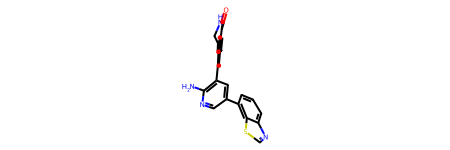

In [22]:
suppl = Chem.SDMolSupplier(str(sdf_file))
mol = []
for m in suppl:
    mol.append(m)
assert len(mol) == 1
mol = mol[0]
mol

In [23]:
mol.GetNumAtoms()

27

In [36]:
mols=[mol]
docking_score = compute_docking_scores(model, residues, dataset_info, hparams, args, device, len(mols), residues_10A, mols)
docking_score.cpu()

tensor([5.5767])

In [33]:
all_mols_2d = []
all_mols_3d = []

its = 1

for i in range(its):
    molecules = prepare_data_and_generate_ligands(
                            model,
                            residues,
                            sdf_file,
                            dataset_info,
                            hparams=hparams,
                            args=args,
                            device=device,
                            embedding_dict=embedding_dict,
                            residues_10A=residues_10A,
                            inner_verbose=True,
                        )
    
    molecules = [m.rdkit_mol for m in molecules]
    all_mols_3d.append(molecules)
    
    molecules = [m for m in molecules if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
    
    if i == 0:
        # insert the first index as seed/reference ligand
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(mol))] + [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
    else:
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
        
    all_mols_2d.append(mols2d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:44<00:00,  2.23it/s]


In [37]:
all_mols_flat = np.concatenate(all_mols_2d)
unique_smiles = []
for m in all_mols_flat:
    unique_smiles.append(Chem.MolToSmiles(m))
unique_smiles = list(set(unique_smiles))
print(f"Uniqueness={len(unique_smiles) / len(all_mols_flat):.4f}")
valid_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in all_mols_flat]
validity = sum((a is not None for a in valid_mols)) / len(valid_mols)
print(f"Validity={validity:.4f}")

Uniqueness=1.0000
Validity=1.0000


In [38]:
natoms = np.array([m.GetNumAtoms() for m in all_mols_flat])
assert (natoms == mol.GetNumAtoms()).all()

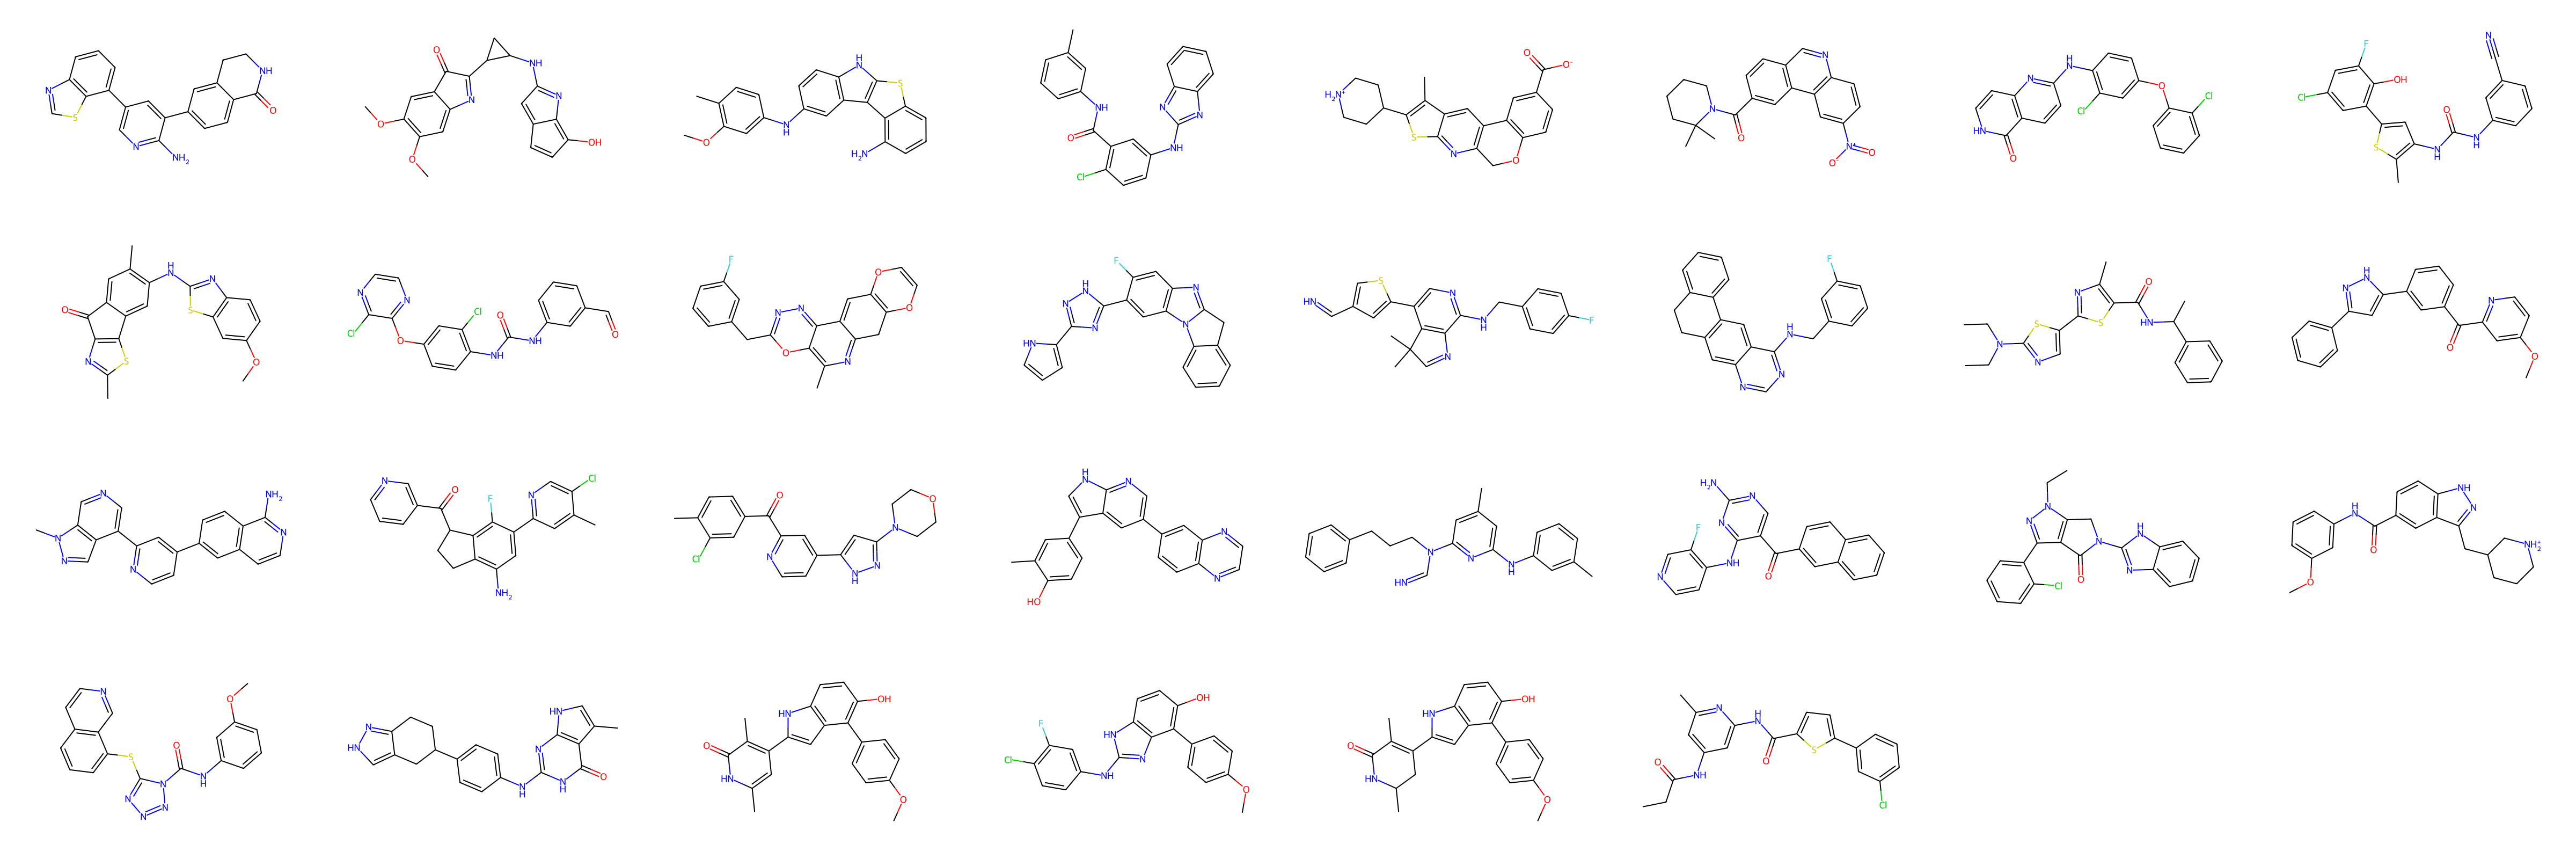

In [39]:
img=rdkit.Chem.Draw.MolsToGridImage(all_mols_flat ,
                                    molsPerRow=8,
                                    subImgSize=(600, 400),
                                    returnPNG=False
                                   )
img

### Lets check the sa_score

In [40]:
sas_conditional = np.array([calculate_sa(m).item() for m in all_mols_flat[1:]])

In [41]:
print(f"SA score of seed ligand: {calculate_sa(all_mols_flat[0]).item():.4f}")
print(f"Mean SA score in generated set: {np.mean(sas_conditional):.4f}")

SA score of seed ligand: 0.8105
Mean SA score in generated set: 0.7910


In [42]:
mols=[mol]
docking_score = compute_docking_scores(model, residues, dataset_info, hparams, args, device, len(mols), residues_10A, mols)
d = docking_score.cpu().item()
print(f"Docking score of reference/seed ligand = {d:.4f}")

Docking score of reference/seed ligand = 5.6041


In [43]:
all_mols_3d_filtered = []
for m in all_mols_3d[0]:
    try:
        s = Chem.MolFromSmiles(Chem.MolToSmiles(m))
        all_mols_3d_filtered.append(m)
    except:
        pass
print(len(all_mols_3d_filtered))
all_mols_3d_filtered = [m for m in all_mols_3d_filtered if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
mols=all_mols_3d_filtered
docking_score = compute_docking_scores(model, residues, dataset_info, hparams, args, device, len(mols), residues_10A, mols)
d = docking_score.cpu().numpy()
print(f"Mean Docking score of generated ligands = {np.mean(d):.4f}")

32
Mean Docking score of generated ligands = 6.8428


### Comparison on unconditional sampling
Let us compare the sa_score if we generate ligands without the sa_score conditioning.
We set `sa_importance_sampling=False`

In [44]:
d = {
     'num_gpus': 1, 
     'fix_n_nodes': True,
     'vary_n_nodes': False,
     'n_nodes_bias': 0,
     'prior_n_atoms': 'targetdiff',

     'sa_importance_sampling': False, 'sa_tau': 0.1, 'sa_every_importance_t': 5,
     'sa_importance_sampling_start': 0, 'sa_importance_sampling_end': 200,
    
     'property_importance_sampling': False, 'property_tau': 0.1, 'property_every_importance_t': 5,
     'property_importance_sampling_start': 250, 'property_importance_sampling_end': 350, 
    
     'test_dir': "./pilot_folder/kinodata/dataset/test", 
     'pdbqt_dir': "./pilot_folder/kinodata/dataset/test/pdbqt/",
    
     'batch_size': 32,
     'property_normalization': False,
}

d.update(defaults_d)
args = DotDict.from_dict(d)
embedding_dict = defaultdict(create_list_defaultdict)
hparams = model.hparams

In [45]:
all_mols_2d = []
all_mols_3d = []

its = 1

for i in range(its):
    molecules = prepare_data_and_generate_ligands(
                            model,
                            residues,
                            sdf_file,
                            dataset_info,
                            hparams=hparams,
                            args=args,
                            device=device,
                            embedding_dict=embedding_dict,
                            residues_10A=residues_10A,
                            inner_verbose=True,
                        )
    
    molecules = [m.rdkit_mol for m in molecules]
    all_mols_3d.append(molecules)
    
    molecules = [m for m in molecules if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
    
    if i == 0:
        # insert the first index as seed/reference ligand
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(mol))] + [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
    else:
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
        
    all_mols_2d.append(mols2d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:27<00:00,  2.41it/s]


In [49]:
all_mols_flat = np.concatenate(all_mols_2d)
unique_smiles = []
for m in all_mols_flat:
    unique_smiles.append(Chem.MolToSmiles(m))
unique_smiles = list(set(unique_smiles))
print(f"Uniqueness={len(unique_smiles) / len(all_mols_flat):.4f}")
valid_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in all_mols_flat]
validity = sum((a is not None for a in valid_mols)) / len(valid_mols)
print(f"Validity={validity:.4f}")

Uniqueness=1.0000
Validity=1.0000


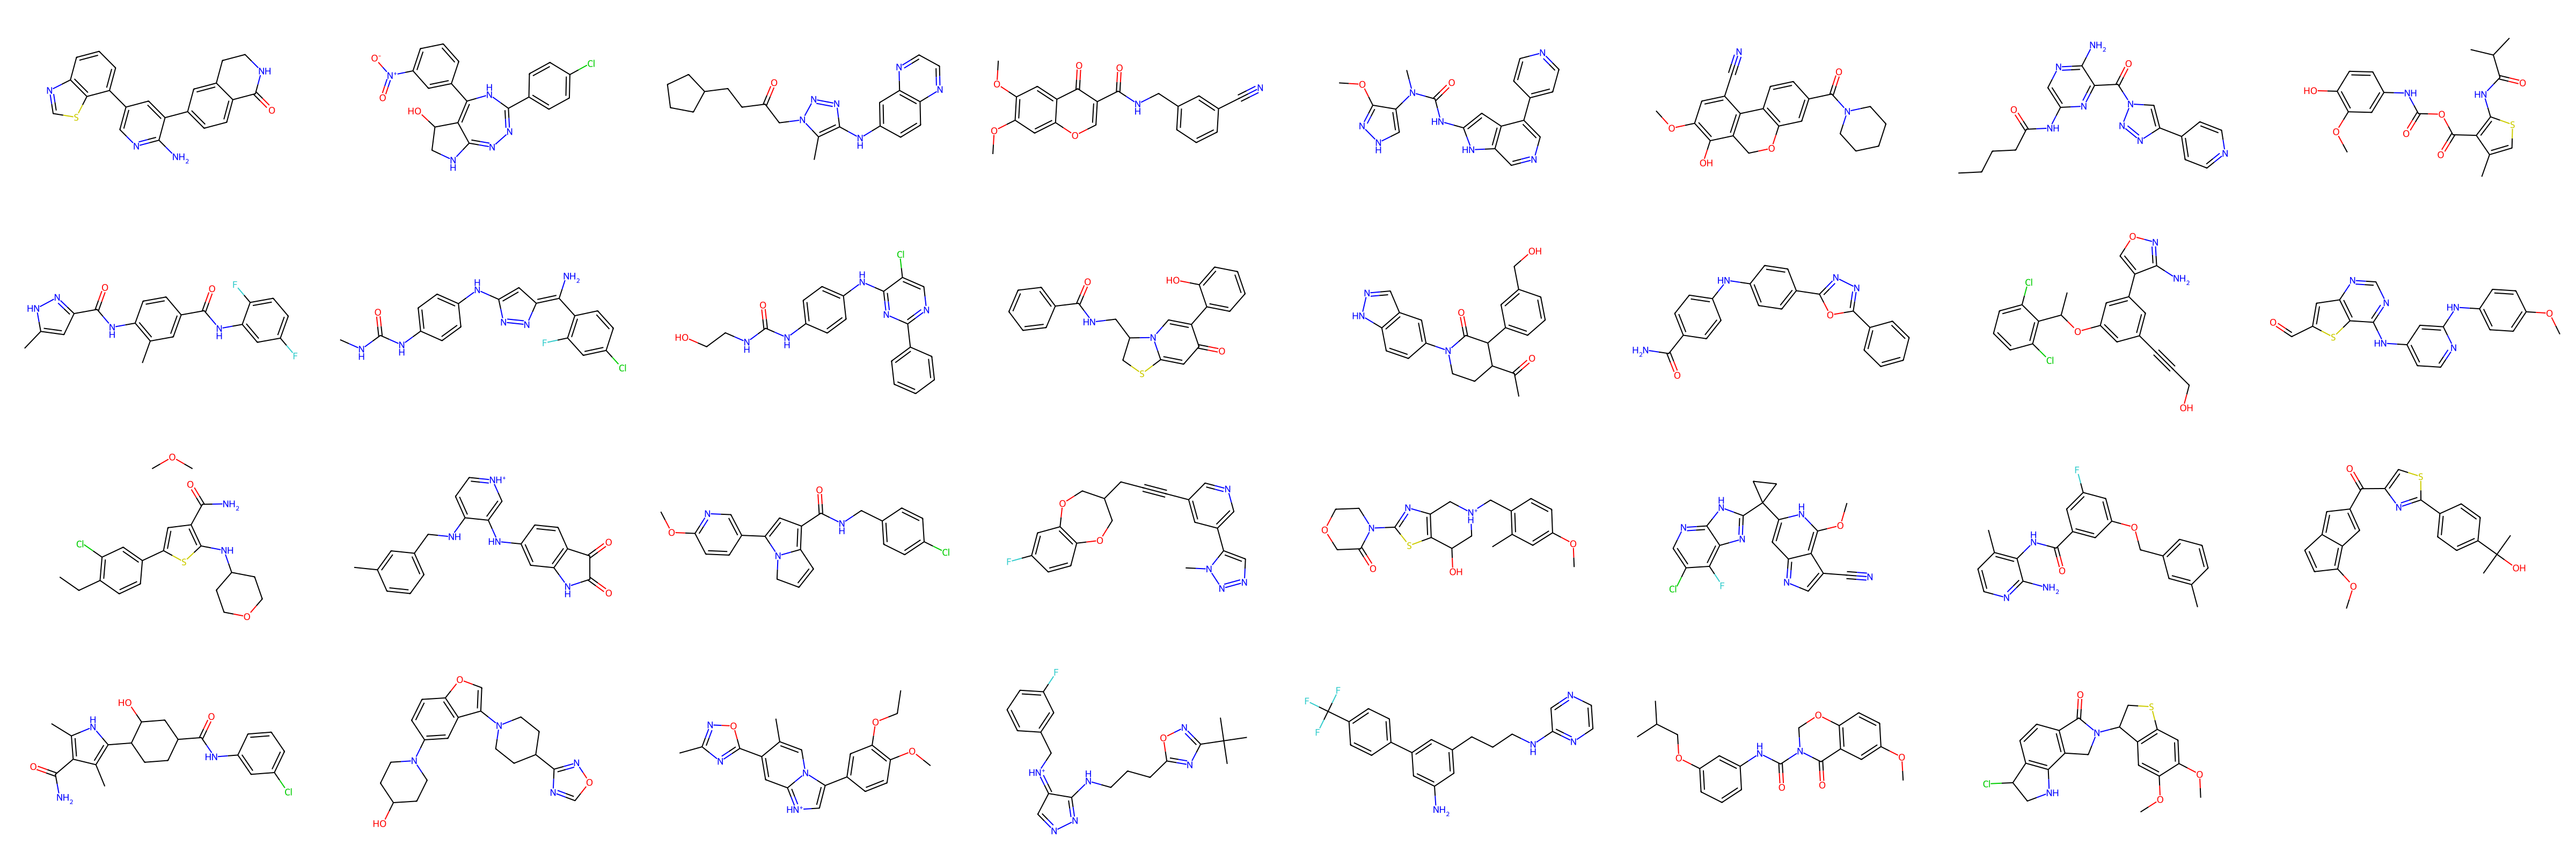

In [50]:
img=rdkit.Chem.Draw.MolsToGridImage(all_mols_flat ,
                                    molsPerRow=8,
                                    subImgSize=(600, 400),
                                    returnPNG=False
                                   )
img

In [51]:
sas_unconditional = np.array([calculate_sa(m).item() for m in all_mols_flat[1:]])
print(f"SA score of seed ligand: {calculate_sa(all_mols_flat[0]).item():.4f}")
print(f"Mean SA score in conditional generated set: {np.mean(sas_conditional):.4f}")
print(f"Mean SA score in unconditional generated set: {np.mean(sas_unconditional):.4f}")

SA score of seed ligand: 0.8105
Mean SA score in conditional generated set: 0.7910
Mean SA score in unconditional generated set: 0.7809


The SA is in the conditional case slightly better.

In [52]:
all_mols_3d_filtered = []
for m in all_mols_3d[0]:
    try:
        s = Chem.MolFromSmiles(Chem.MolToSmiles(m))
        all_mols_3d_filtered.append(m)
    except:
        pass
print(len(all_mols_3d_filtered))
all_mols_3d_filtered = [m for m in all_mols_3d_filtered if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
mols=all_mols_3d_filtered
docking_score = compute_docking_scores(model, residues, dataset_info, hparams, args, device, len(mols), residues_10A, mols)
d = docking_score.cpu().numpy()
print(f"Mean Docking score of generated ligands = {np.mean(d):.4f}")

32
Mean Docking score of generated ligands = 6.7376


The precticed pIC50 score is slightly reduced when SA maximization is performed

## pIC50 Guidance

In [57]:
d = {
     'num_gpus': 1, 
     'fix_n_nodes': True,
     'vary_n_nodes': False,
     'n_nodes_bias': 0,
     'prior_n_atoms': 'targetdiff',

     'sa_importance_sampling': False, 'sa_tau': 0.1, 'sa_every_importance_t': 4,
     'sa_importance_sampling_start': 0, 'sa_importance_sampling_end': 250,
    
     'property_importance_sampling': True, 'property_tau': 0.1, 'property_every_importance_t': 5,
     'property_importance_sampling_start': 0, 'property_importance_sampling_end': 300, 
    
     'test_dir': "./pilot_folder/kinodata/dataset/test", 
     'pdbqt_dir': "./pilot_folder/kinodata/dataset/test/pdbqt/",
    
     'batch_size': 32,
     'property_normalization': False,
}

d.update(defaults_d)
args = DotDict.from_dict(d)
embedding_dict = defaultdict(create_list_defaultdict)
hparams = model.hparams

all_mols_2d = []
all_mols_3d = []

its = 1

for i in range(its):
    molecules = prepare_data_and_generate_ligands(
                            model,
                            residues,
                            sdf_file,
                            dataset_info,
                            hparams=hparams,
                            args=args,
                            device=device,
                            embedding_dict=embedding_dict,
                            residues_10A=residues_10A,
                            inner_verbose=True,
                        )
    
    molecules = [m.rdkit_mol for m in molecules]
    all_mols_3d.append(molecules)
    
    molecules = [m for m in molecules if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
    
    if i == 0:
        # insert the first index as seed/reference ligand
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(mol))] + [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
    else:
        mols2d = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in molecules]
        
    all_mols_2d.append(mols2d)

all_mols_flat = np.concatenate(all_mols_2d)
unique_smiles = []
for m in all_mols_flat:
    unique_smiles.append(Chem.MolToSmiles(m))
unique_smiles = list(set(unique_smiles))
print(f"Uniqueness={len(unique_smiles) / len(all_mols_flat):.4f}")
valid_mols = [Chem.MolFromSmiles(Chem.MolToSmiles(m)) for m in all_mols_flat]
validity = sum((a is not None for a in valid_mols)) / len(valid_mols)
print(f"Validity={validity:.4f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:54<00:00,  2.13it/s]

Uniqueness=1.0000
Validity=1.0000


In [58]:
pic50_conditional_more = np.array([calculate_sa(m).item() for m in all_mols_flat[1:]])
print(f"SA score of seed ligand: {calculate_sa(all_mols_flat[0]).item():.4f}")
print(f"Mean SA score in unconditional generated set: {np.mean(sas_unconditional):.4f}")
print(f"Mean SA score in pic50 generated set: {np.mean(pic50_conditional_more):.4f}")

SA score of seed ligand: 0.8105
Mean SA score in unconditional generated set: 0.7809
Mean SA score in pic50 generated set: 0.5999


In [59]:
all_mols_3d_filtered = []
for m in all_mols_3d[0]:
    try:
        s = Chem.MolFromSmiles(Chem.MolToSmiles(m))
        all_mols_3d_filtered.append(m)
    except:
        pass
print(len(all_mols_3d_filtered))
all_mols_3d_filtered = [m for m in all_mols_3d_filtered if Chem.MolFromSmiles(Chem.MolToSmiles(m)) is not None]
mols=all_mols_3d_filtered
docking_score = compute_docking_scores(model, residues, dataset_info, hparams, args, device, len(mols), residues_10A, mols)
d = docking_score.cpu().numpy()
print(f"Mean pIC50 score of conditional generated ligands = {np.mean(d):.4f}")

32
Mean pIC50 score of conditional generated ligands = 7.3252


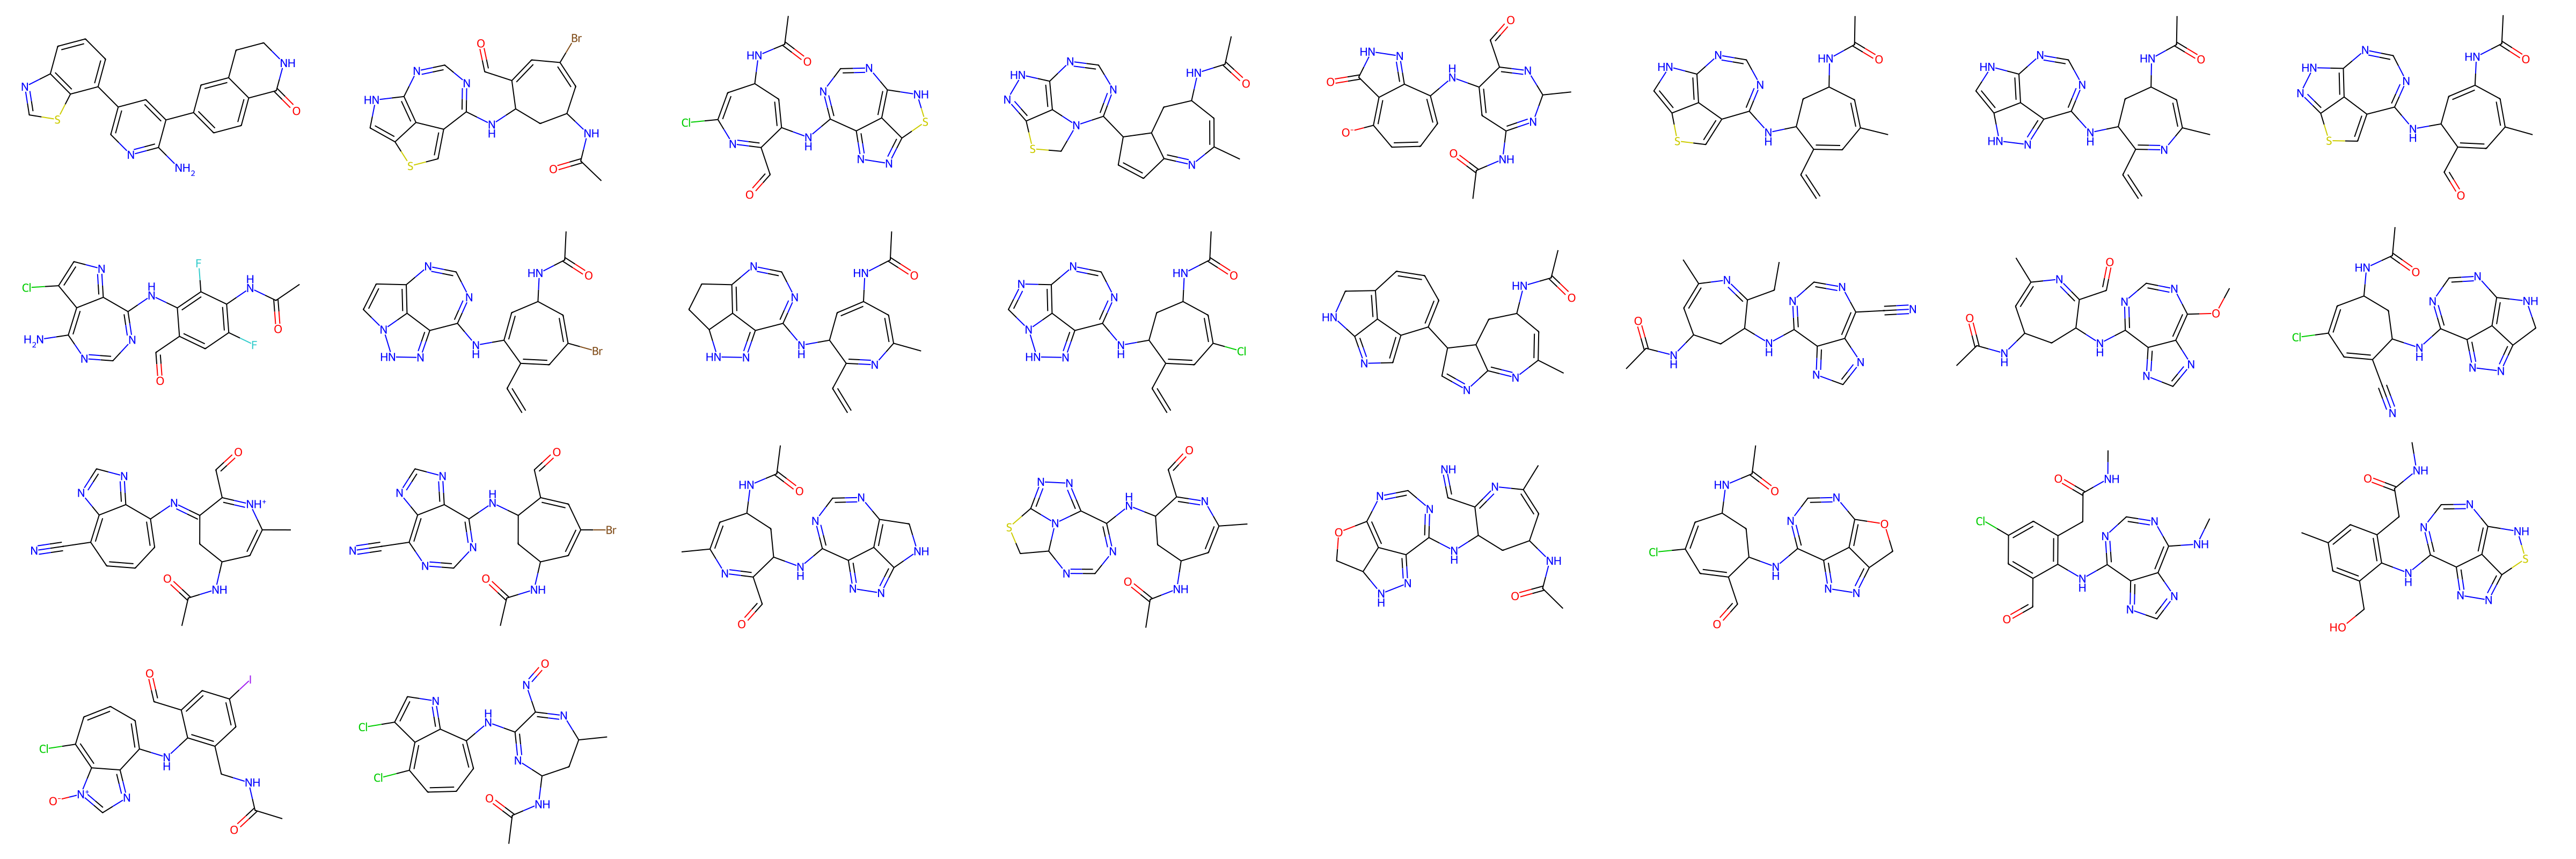

In [60]:
img=rdkit.Chem.Draw.MolsToGridImage(all_mols_flat ,
                                    molsPerRow=8,
                                    subImgSize=(600, 400),
                                    returnPNG=False
                                   )
img